In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tqdm

In [2]:
file = open('./data/shashlik_61_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])

In [3]:
data.shape

(7848, 1026)

In [4]:
print("Experiments number:", data.shape[0])

Experiments number: 7848


In [5]:
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

### Normalize y

In [6]:
y = y - np.mean(y)

In [7]:
y_baseline = y_baseline - np.mean(y_baseline)

### Model

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures

In [9]:
def print_lr_scores(X, reg=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(reg, X, y, scoring=scoring, cv=5)
    
    print("95% confidence interval:")
    print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
    print("MSE: %0.5f (+/- %0.5f)" % (-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std() * 2))
    print("MAE: %0.5f (+/- %0.5f)" % (-scores['test_neg_mean_absolute_error'].mean(), scores['test_neg_mean_absolute_error'].std() * 2))

#### Linear regression metrics

In [10]:
print_lr_scores(X)

95% confidence interval:
r2_score: 0.99904 (+/- 0.00008)
MSE: 0.15693 (+/- 0.01474)
MAE: 0.30628 (+/- 0.01495)


#### Baseline metrics

In [11]:
print("r2_score:", r2_score(y, y_baseline))
print("MSE:", mean_squared_error(y, y_baseline))
print("MAE:", mean_absolute_error(y, y_baseline))

r2_score: 0.9994485733281531
MSE: 0.08974125778045815
MAE: 0.23497220510936273


### Let's plot errors distribution

##### Train-test split

In [12]:
X_train, X_test, y_train, y_test, y_baseline_train, y_baseline_test = train_test_split(X, y, y_baseline, test_size=0.33, random_state=42)

In [13]:
reg = LinearRegression().fit(X_train, y_train)

In [14]:
predicted = reg.predict(X_test)

In [15]:
regression_diff = predicted - y_test

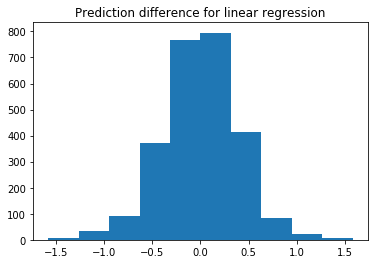

In [16]:
plt.title("Prediction difference for linear regression")
plt.hist(regression_diff)
plt.show()

In [17]:
baseline_diff = y_baseline_test - y_test

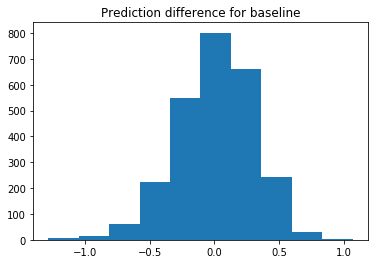

In [18]:
plt.title("Prediction difference for baseline")
plt.hist(baseline_diff)
plt.show()

### Experiments with signal frequency

In [19]:
def plot_errors(model, frequency_values, start_point=355):
    r2_scores = []
    mse_scores = []
    mae_scores = []

    for freq in tqdm.tqdm(frequency_values):
        X_freq = np.concatenate([X[:, start_point::-freq], X[:, start_point::freq]], axis=1)

        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X_freq, y, scoring=scoring, cv=5)

        r2_scores.append(scores['test_r2'].mean())
        mse_scores.append(scores['test_neg_mean_squared_error'].mean())
        mae_scores.append(scores['test_neg_mean_absolute_error'].mean())
        
    plt.title("R2 score dependency on number of samples for " + type(model).__name__)
    plt.plot(frequency_values, r2_scores)
    plt.show()
    
    plt.title("MSE and MAE dependencies on number of samples for " + type(model).__name__)
    plt.plot(frequency_values, mse_scores)
    plt.plot(frequency_values, mae_scores)
    plt.legend(('MSE', 'MAE'),
               loc='lower left')
    plt.show()

100%|██████████| 998/998 [00:27<00:00, 36.84it/s]


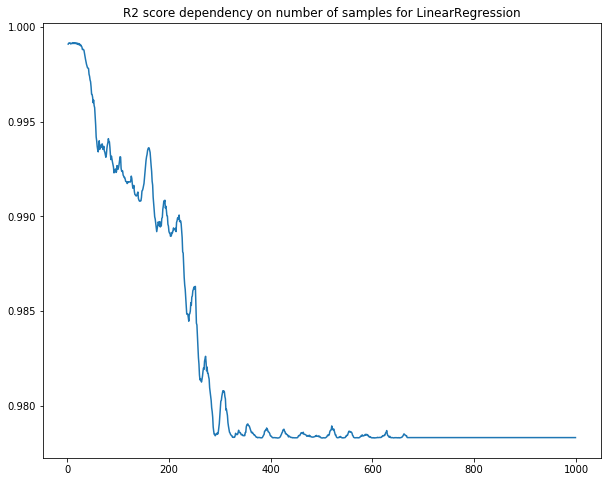

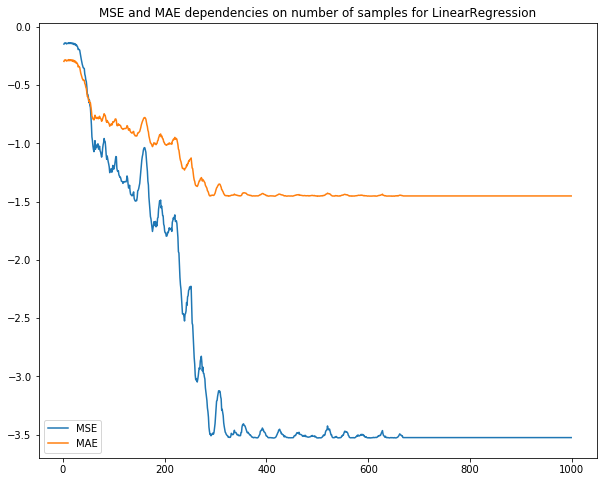

100%|██████████| 98/98 [00:11<00:00,  8.78it/s]


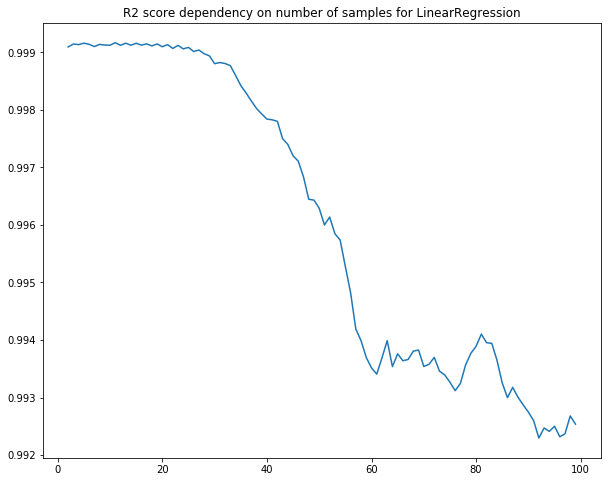

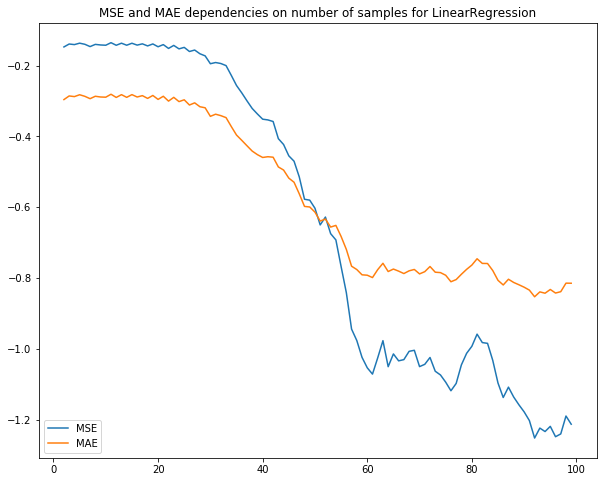

In [20]:
plt.rcParams["figure.figsize"] = [10, 8]

reg = LinearRegression()

frequency_values = range(2, 1000)
plot_errors(reg, frequency_values)

frequency_values = range(2, 100)
plot_errors(reg, frequency_values)

100%|██████████| 998/998 [10:47<00:00,  1.54it/s] 


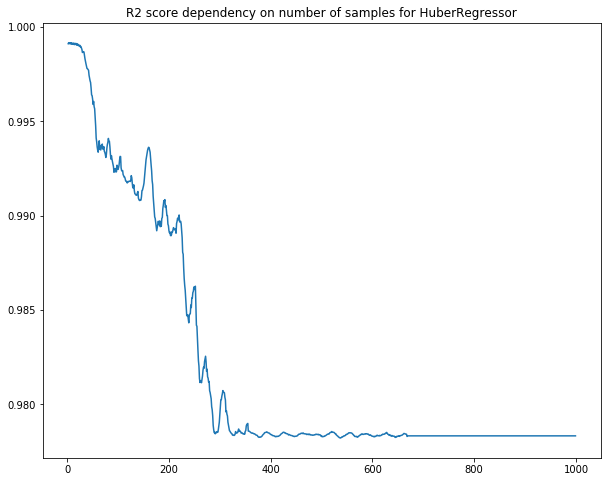

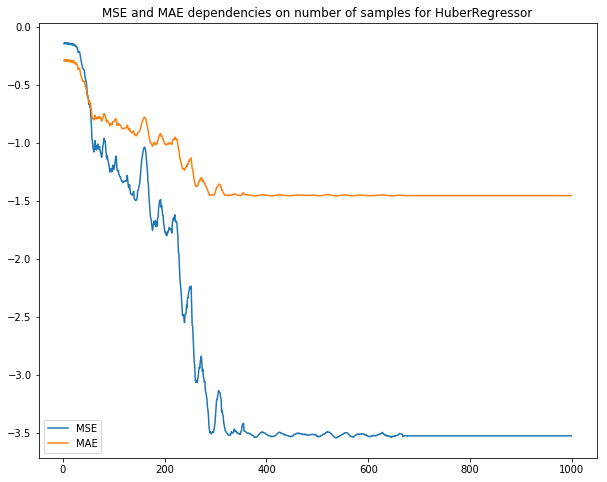

100%|██████████| 98/98 [03:17<00:00,  2.01s/it]


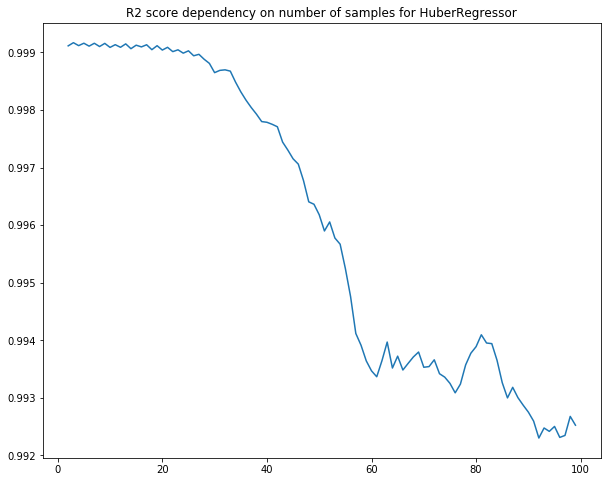

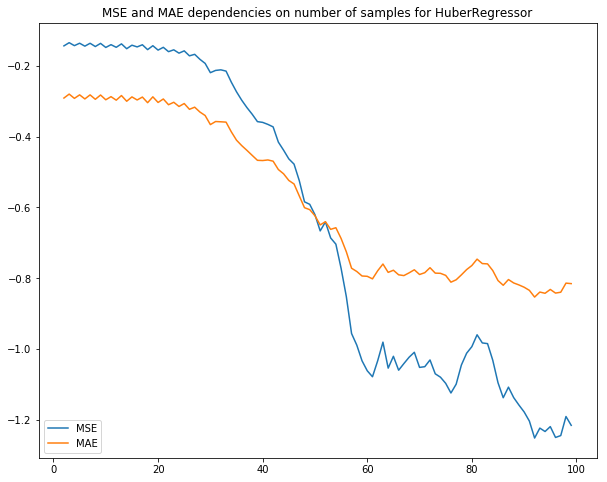

In [21]:
from sklearn.linear_model import HuberRegressor

huber_reg = HuberRegressor(epsilon= 5.09, alpha= 0.0004)


frequency_values = range(2, 1000)
plot_errors(huber_reg, frequency_values)

frequency_values = range(2, 100)
plot_errors(huber_reg, frequency_values)

In [22]:
X = X[:1000]
y = y[:1000]

100%|██████████| 998/998 [05:57<00:00,  2.80it/s] 


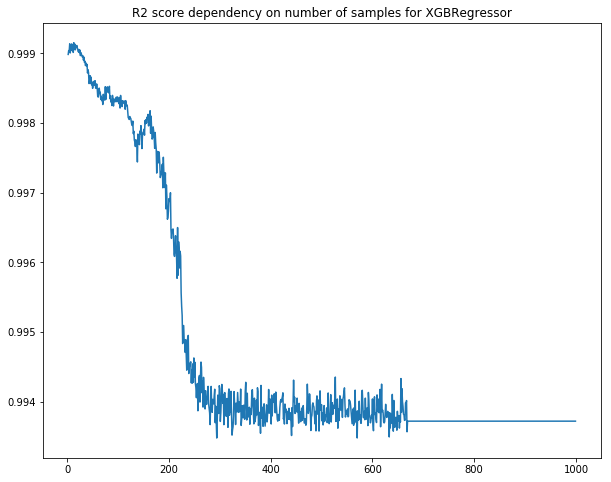

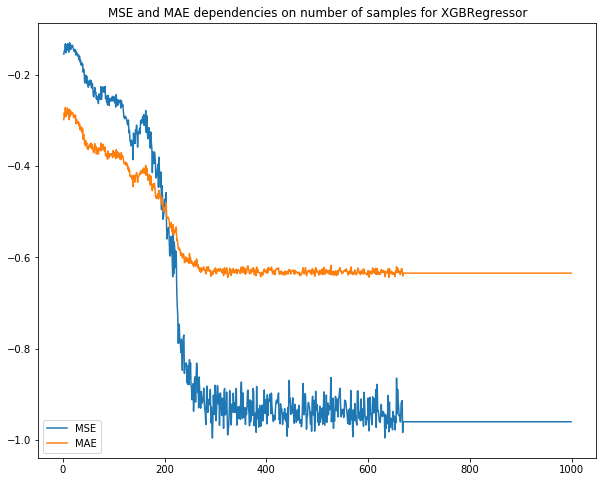

100%|██████████| 98/98 [02:41<00:00,  1.65s/it]


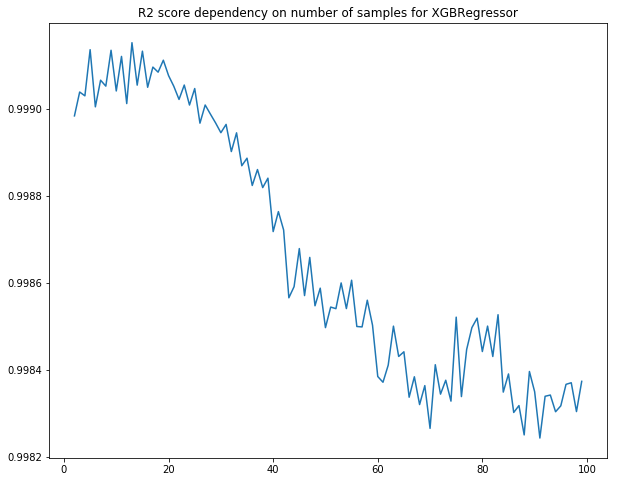

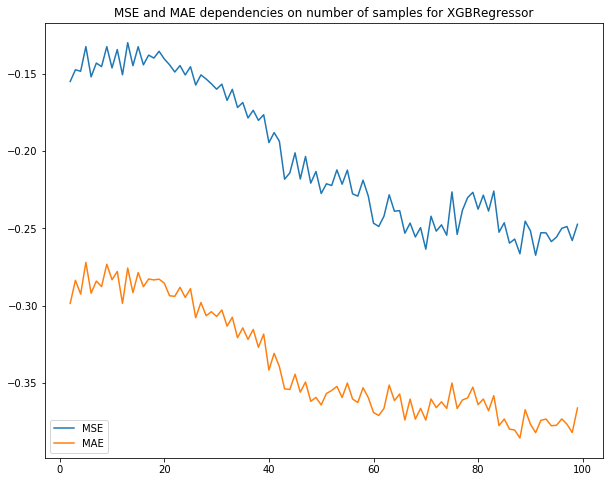

In [23]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", random_state=42, verbosity=0)

frequency_values = range(2, 1000)
plot_errors(xgb_reg, frequency_values)

frequency_values = range(2, 100)
plot_errors(xgb_reg, frequency_values)

In [ ]:
frequency_values = range(2, 100)

plot_errors(LinearRegression(), frequency_values)

#### As we may see, if we take freq = 20, we significantly reduce the size of our data and have the same errors rate

### Trying other models

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [39]:
freq = 20
start_point = 355

X = np.concatenate([X[:, start_point::-freq], X[:, start_point::freq]], axis=1)

In [40]:
X.shape

(7848, 52)

In [41]:
poly = PolynomialFeatures(2)
X_polynomial = poly.fit_transform(X)

In [42]:
X_polynomial.shape

(7848, 1431)

In [43]:
print("Linear regresssion metrics:")
print_lr_scores(X)

Linear regresssion metrics:
95% confindence interval:
r2_score: 0.99910 (+/- 0.00006)
MSE: 0.14703 (+/- 0.01111)
MAE: 0.29564 (+/- 0.01264)


In [44]:
print("Polynomial linear regression metrics:")
print_lr_scores(X_polynomial)

Polynomial linear regression metrics:
95% confindence interval:
r2_score: 0.99961 (+/- 0.00002)
MSE: 0.06373 (+/- 0.00395)
MAE: 0.19767 (+/- 0.00591)


In [45]:
print("Baseline metrics:")
print("r2_score:", r2_score(y, y_baseline))
print("MSE:", mean_squared_error(y, y_baseline))
print("MAE:", mean_absolute_error(y, y_baseline))

Baseline metrics:
r2_score: 0.9994485733281531
MSE: 0.08974125778045815
MAE: 0.23497220510936273


###### Linear regression provides worse result than the baseline solution, but we can beat the baseline solution with adding polynomial features

### Huber Regressor

In [47]:
from sklearn.linear_model import HuberRegressor

In [48]:
huber = HuberRegressor()

In [49]:
print_lr_scores(X, huber)

95% confindence interval:
r2_score: 0.99906 (+/- 0.00008)
MSE: 0.15299 (+/- 0.01295)
MAE: 0.30164 (+/- 0.01305)


In [50]:
print_lr_scores(X_polynomial, huber)

95% confindence interval:
r2_score: 0.99941 (+/- 0.00007)
MSE: 0.09641 (+/- 0.01677)
MAE: 0.24163 (+/- 0.02070)


### Ridge linear regression

In [51]:
from sklearn import linear_model
ridge_reg = linear_model.Ridge(alpha=.5)

In [52]:
print_lr_scores(X, ridge_reg)

95% confindence interval:
r2_score: 0.99910 (+/- 0.00006)
MSE: 0.14706 (+/- 0.01099)
MAE: 0.29566 (+/- 0.01244)


In [53]:
print_lr_scores(X_polynomial, ridge_reg)

95% confindence interval:
r2_score: 0.99961 (+/- 0.00002)
MSE: 0.06302 (+/- 0.00398)
MAE: 0.19658 (+/- 0.00580)


### Lasso linear regression

In [54]:
lasso_reg = linear_model.Lasso(alpha=0.1)

In [55]:
print_lr_scores(X, lasso_reg)

/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

95% confindence interval:
r2_score: 0.99908 (+/- 0.00007)
MSE: 0.15038 (+/- 0.01211)
MAE: 0.29950 (+/- 0.01433)


/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [56]:
print_lr_scores(X_polynomial, lasso_reg)

/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not conver

95% confindence interval:
r2_score: 0.99956 (+/- 0.00001)
MSE: 0.07211 (+/- 0.00367)
MAE: 0.20930 (+/- 0.00561)


/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Decision trees

In [57]:
from sklearn import tree

dt_reg = tree.DecisionTreeRegressor()

In [58]:
print_lr_scores(X, dt_reg)

95% confindence interval:
r2_score: 0.99881 (+/- 0.00018)
MSE: 0.19336 (+/- 0.02436)
MAE: 0.34003 (+/- 0.01891)


In [59]:
print_lr_scores(X_polynomial, dt_reg)

95% confindence interval:
r2_score: 0.99888 (+/- 0.00005)
MSE: 0.18170 (+/- 0.00699)
MAE: 0.32915 (+/- 0.00732)


### SVM

In [60]:
from sklearn import svm

In [61]:
svm_reg = svm.SVR()

In [62]:
print_lr_scores(X, svm_reg)

/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/pavel/anaconda3/lib/python3.7/site-packages/sklearn/

95% confindence interval:
r2_score: -0.00096 (+/- 0.00135)
MSE: 162.82265 (+/- 9.49223)
MAE: 10.90944 (+/- 0.37305)


In [64]:
# print_lr_scores(X_polynomial, svm_reg)

### Passive aggresive

In [65]:
from sklearn.linear_model import PassiveAggressiveRegressor

In [66]:
pa_reg = PassiveAggressiveRegressor(max_iter=1000, random_state=0, tol=1e-3)

In [67]:
print_lr_scores(X, pa_reg)

95% confindence interval:
r2_score: 0.99894 (+/- 0.00008)
MSE: 0.17244 (+/- 0.00563)
MAE: 0.32046 (+/- 0.01652)


In [68]:
print_lr_scores(X_polynomial, pa_reg)

95% confindence interval:
r2_score: 0.99804 (+/- 0.00190)
MSE: 0.31692 (+/- 0.30276)
MAE: 0.45522 (+/- 0.27130)


### Xgboost

In [71]:
import xgboost as xgb

In [72]:
xgb_reg = xgb.XGBRegressor(objective="reg:linear", random_state=42)

In [73]:
print_lr_scores(X, xgb_reg)

[15:32:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:32:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
95% confindence interval:
r2_score: 0.99939 (+/- 0.00005)
MSE: 0.09974 (+/- 0.00859)
MAE: 0.24625 (+/- 0.00999)


In [74]:
print_lr_scores(X_polynomial, xgb_reg)

[15:32:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:33:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:34:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:35:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
95% confindence interval:
r2_score: 0.99939 (+/- 0.00006)
MSE: 0.10001 (+/- 0.01135)
MAE: 0.24677 (+/- 0.01115)


### Catboost

In [6]:
from catboost import CatBoostRegressor

In [11]:
catboost_reg = CatBoostRegressor(iterations=100,
                          learning_rate=1,
                          depth=5)

In [12]:
print_lr_scores(X, catboost_reg)

0:	learn: 4.6898674	total: 224ms	remaining: 22.2s
1:	learn: 3.4921055	total: 300ms	remaining: 14.7s
2:	learn: 2.9658912	total: 379ms	remaining: 12.3s
3:	learn: 2.6853177	total: 465ms	remaining: 11.2s
4:	learn: 2.3589750	total: 580ms	remaining: 11s
5:	learn: 2.2441001	total: 657ms	remaining: 10.3s
6:	learn: 2.2070159	total: 769ms	remaining: 10.2s
7:	learn: 1.9256363	total: 852ms	remaining: 9.79s
8:	learn: 1.8429953	total: 930ms	remaining: 9.4s
9:	learn: 1.8040305	total: 1.02s	remaining: 9.23s
10:	learn: 1.7851247	total: 1.12s	remaining: 9.06s
11:	learn: 1.6763622	total: 1.2s	remaining: 8.79s
12:	learn: 1.5769994	total: 1.3s	remaining: 8.72s
13:	learn: 1.4978396	total: 1.4s	remaining: 8.57s
14:	learn: 1.4128737	total: 1.47s	remaining: 8.34s
15:	learn: 1.2540242	total: 1.57s	remaining: 8.27s
16:	learn: 1.2201544	total: 1.68s	remaining: 8.2s
17:	learn: 1.1618543	total: 1.76s	remaining: 8.01s
18:	learn: 1.0770021	total: 1.86s	remaining: 7.92s
19:	learn: 1.0464847	total: 1.96s	remaining: 7.8

64:	learn: 0.5972490	total: 8.88s	remaining: 4.78s
65:	learn: 0.5950486	total: 8.98s	remaining: 4.62s
66:	learn: 0.5919441	total: 9.07s	remaining: 4.47s
67:	learn: 0.5892879	total: 9.18s	remaining: 4.32s
68:	learn: 0.5866190	total: 9.27s	remaining: 4.17s
69:	learn: 0.5835523	total: 9.36s	remaining: 4.01s
70:	learn: 0.5804713	total: 9.47s	remaining: 3.87s
71:	learn: 0.5775556	total: 9.56s	remaining: 3.72s
72:	learn: 0.5744169	total: 9.65s	remaining: 3.57s
73:	learn: 0.5712968	total: 9.8s	remaining: 3.44s
74:	learn: 0.5685531	total: 9.96s	remaining: 3.32s
75:	learn: 0.5662464	total: 10.2s	remaining: 3.21s
76:	learn: 0.5638186	total: 10.3s	remaining: 3.08s
77:	learn: 0.5607087	total: 10.4s	remaining: 2.94s
78:	learn: 0.5572810	total: 10.5s	remaining: 2.8s
79:	learn: 0.5557080	total: 10.7s	remaining: 2.69s
80:	learn: 0.5526924	total: 10.9s	remaining: 2.56s
81:	learn: 0.5512818	total: 11s	remaining: 2.42s
82:	learn: 0.5428020	total: 11.2s	remaining: 2.29s
83:	learn: 0.5399366	total: 11.3s	r

26:	learn: 1.0310015	total: 3.5s	remaining: 9.46s
27:	learn: 1.0163914	total: 3.59s	remaining: 9.23s
28:	learn: 1.0080709	total: 3.68s	remaining: 9.01s
29:	learn: 1.0026067	total: 3.79s	remaining: 8.85s
30:	learn: 0.9761702	total: 3.9s	remaining: 8.68s
31:	learn: 0.9678018	total: 4.08s	remaining: 8.68s
32:	learn: 0.9555745	total: 4.27s	remaining: 8.67s
33:	learn: 0.9487810	total: 4.46s	remaining: 8.65s
34:	learn: 0.9440028	total: 4.65s	remaining: 8.63s
35:	learn: 0.9374276	total: 4.78s	remaining: 8.49s
36:	learn: 0.9158769	total: 4.87s	remaining: 8.3s
37:	learn: 0.9114152	total: 4.96s	remaining: 8.09s
38:	learn: 0.8985426	total: 5.08s	remaining: 7.95s
39:	learn: 0.8534976	total: 5.26s	remaining: 7.9s
40:	learn: 0.8488711	total: 5.39s	remaining: 7.76s
41:	learn: 0.8434023	total: 5.52s	remaining: 7.63s
42:	learn: 0.8406809	total: 5.63s	remaining: 7.46s
43:	learn: 0.8367816	total: 5.79s	remaining: 7.37s
44:	learn: 0.8331083	total: 5.94s	remaining: 7.26s
45:	learn: 0.8255878	total: 6.04s	r

89:	learn: 0.6916125	total: 12.3s	remaining: 1.36s
90:	learn: 0.6892031	total: 12.4s	remaining: 1.23s
91:	learn: 0.6859396	total: 12.5s	remaining: 1.09s
92:	learn: 0.6793197	total: 12.6s	remaining: 950ms
93:	learn: 0.6757774	total: 12.7s	remaining: 812ms
94:	learn: 0.6723078	total: 12.8s	remaining: 676ms
95:	learn: 0.6689322	total: 12.9s	remaining: 539ms
96:	learn: 0.6667919	total: 13s	remaining: 403ms
97:	learn: 0.6638657	total: 13.1s	remaining: 268ms
98:	learn: 0.6616720	total: 13.3s	remaining: 135ms
99:	learn: 0.6589300	total: 13.5s	remaining: 0us
95% confindence interval:
r2_score: 0.99138 (+/- 0.00493)
MSE: 1.40912 (+/- 0.84711)
MAE: 0.74518 (+/- 0.19302)


In [ ]:
print_lr_score(X_polynomial, catboost_reg)

In [80]:
np.save("./data/X.npy", X)
np.save("./data/X_polynomial.npy", X_polynomial)
np.save("./data/y.npy", y)

In [81]:
X_saved = np.load('./data/X.npy')

### Impuls graphs for different signal frequencies

In [38]:
    plt.rcParams["figure.figsize"] = [6, 4]

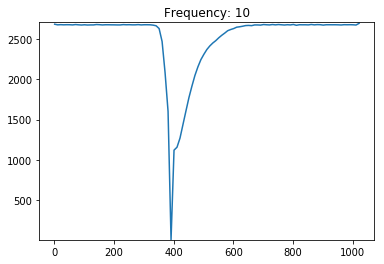

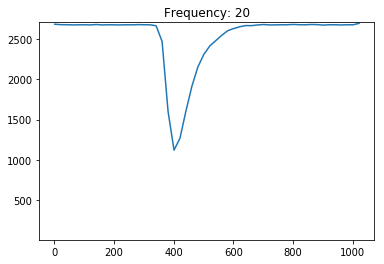

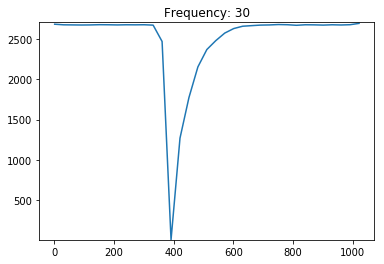

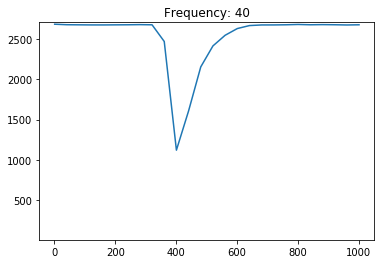

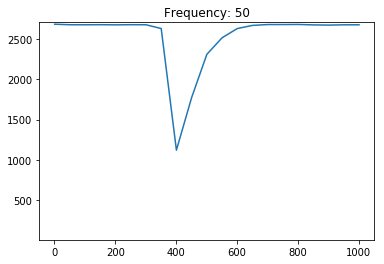

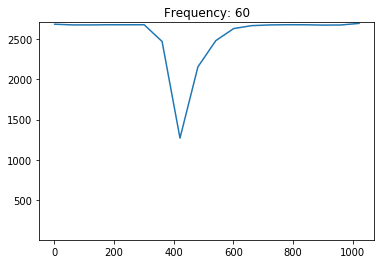

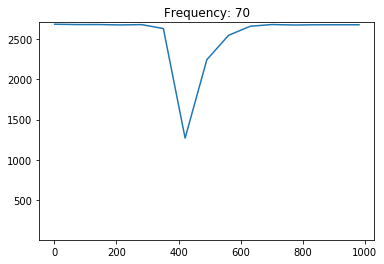

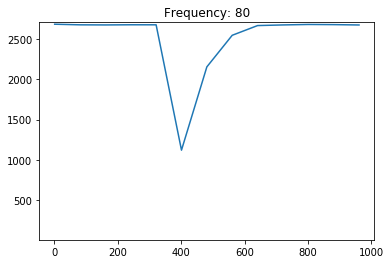

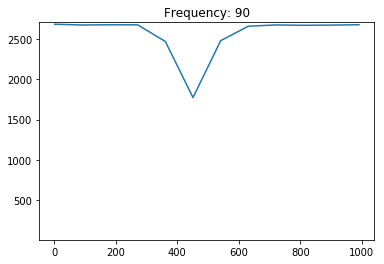

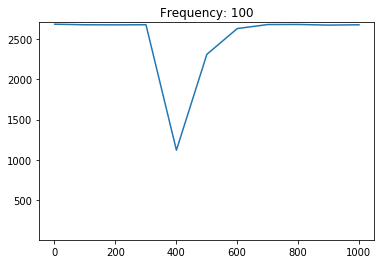

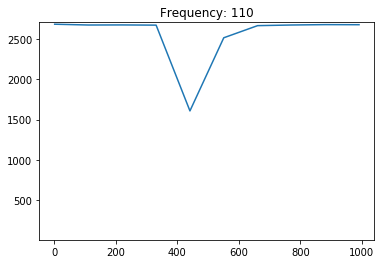

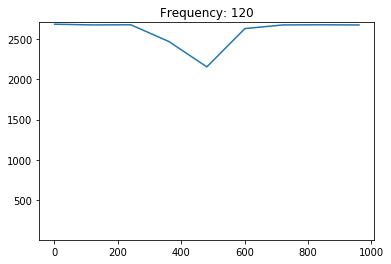

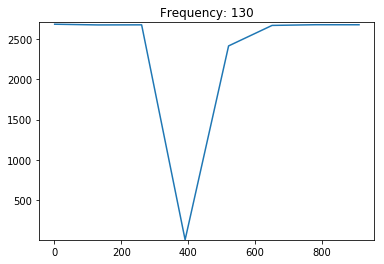

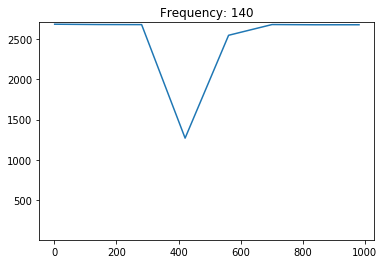

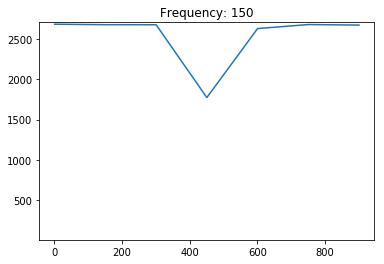

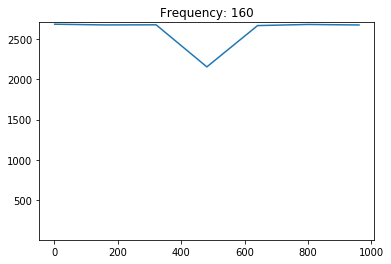

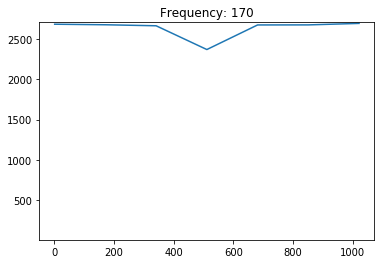

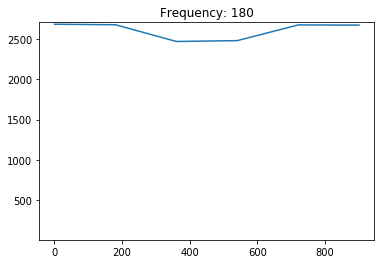

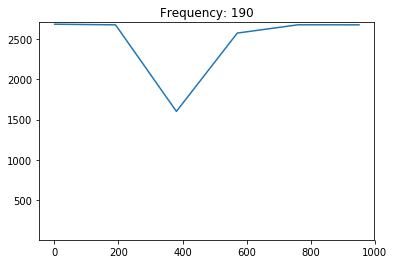

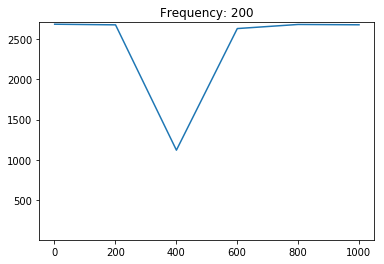

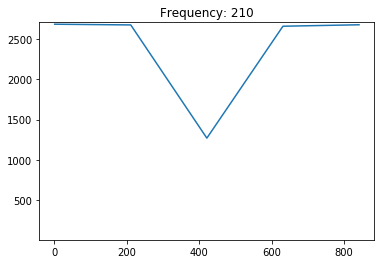

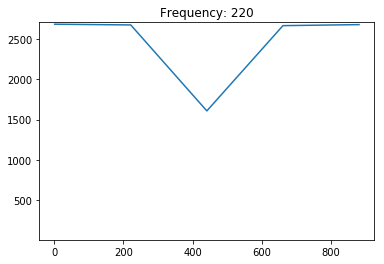

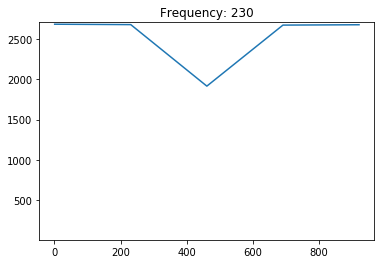

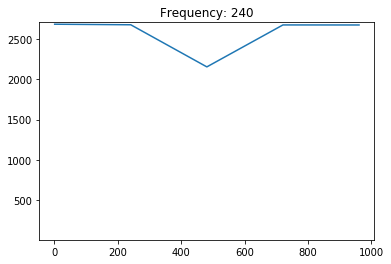

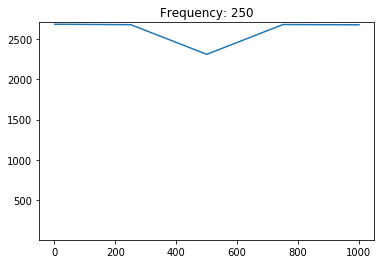

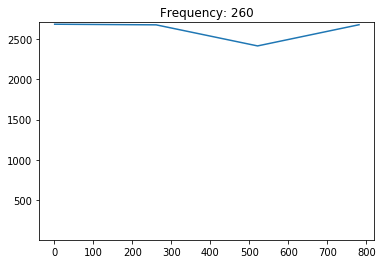

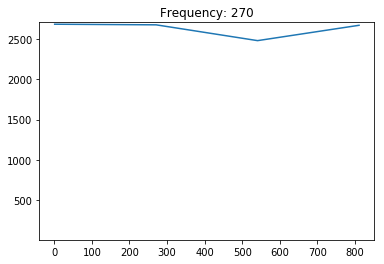

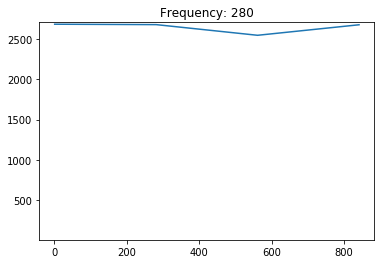

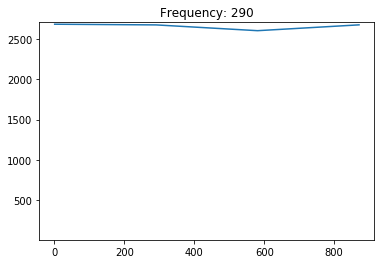

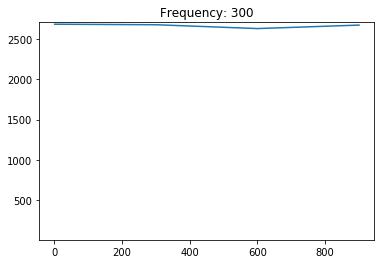

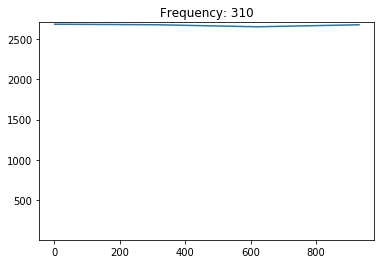

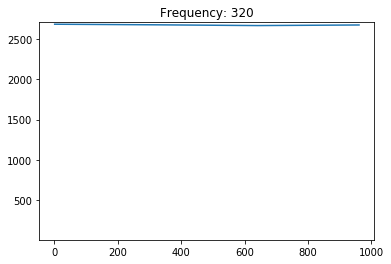

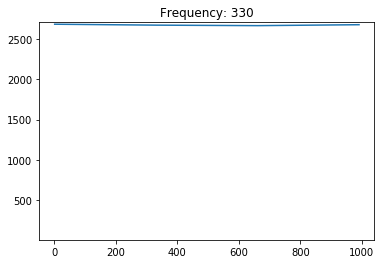

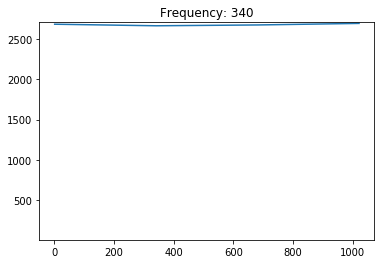

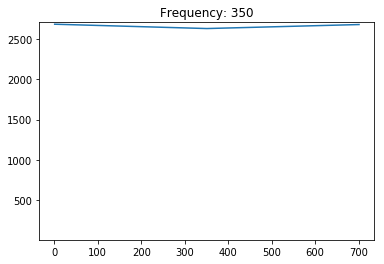

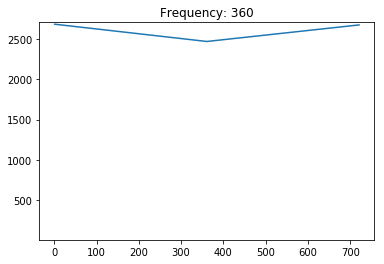

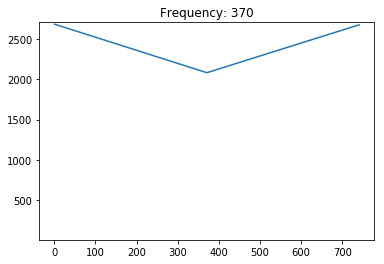

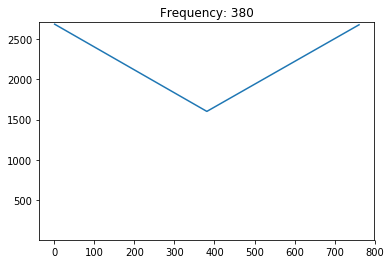

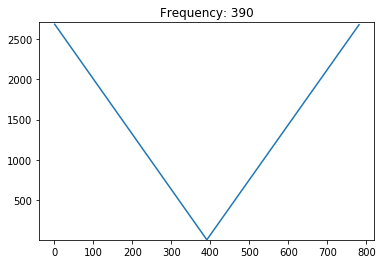

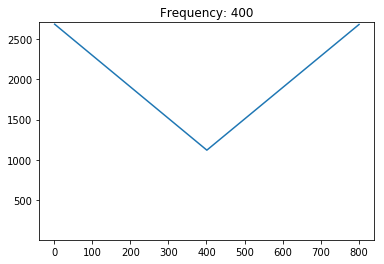

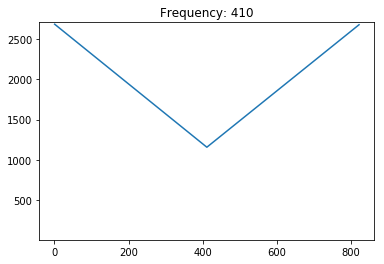

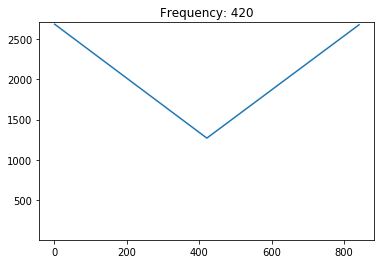

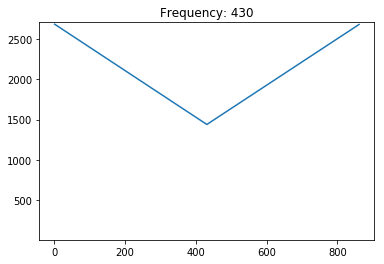

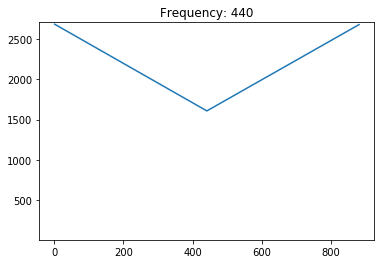

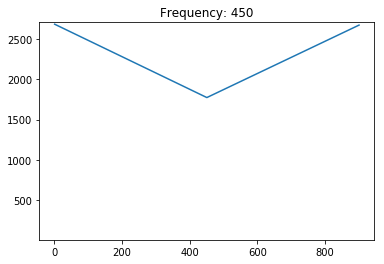

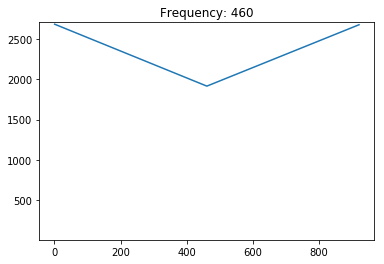

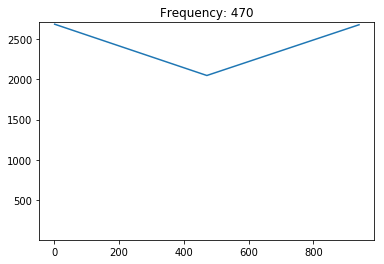

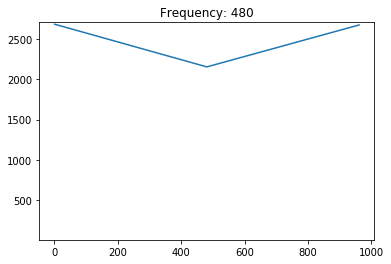

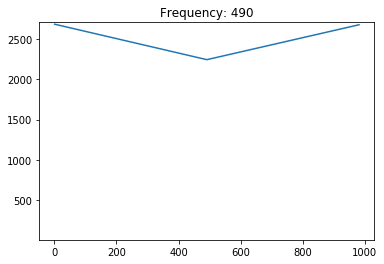

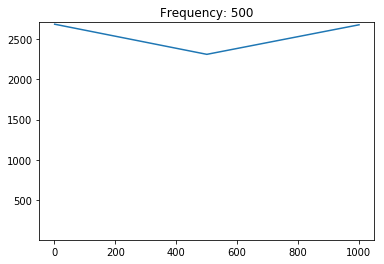

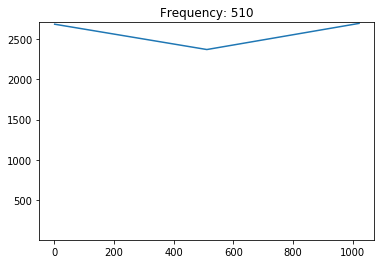

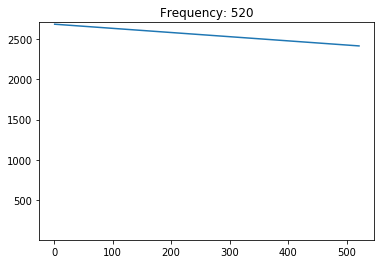

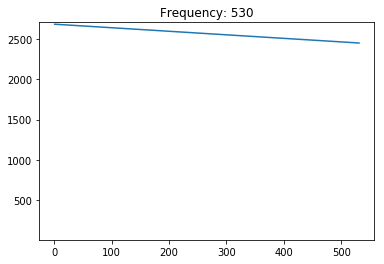

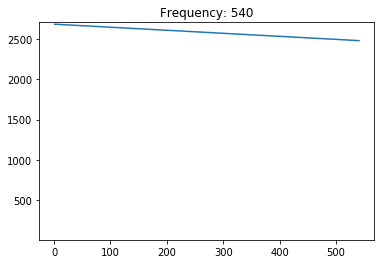

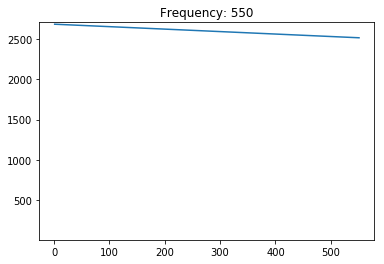

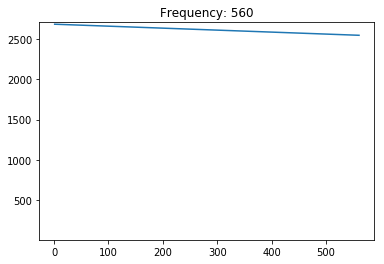

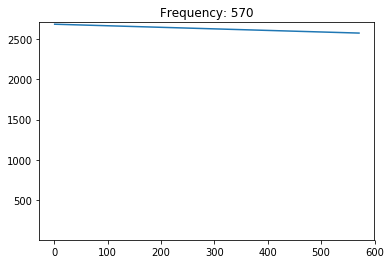

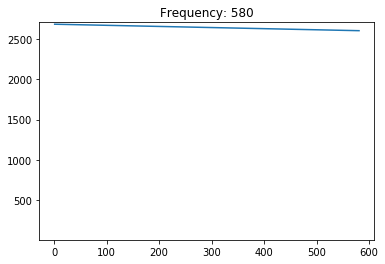

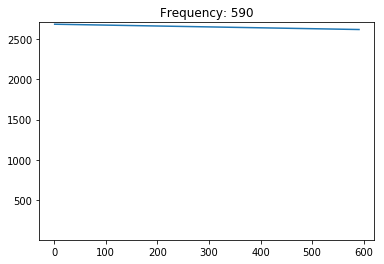

In [39]:
for freq in range(10, 600, 10):
    x = X[0, ::freq]

    plt.title("Frequency: " + str(freq))
    plt.ylim(np.min(X), np.max(X))
    plt.plot(range(1, len(X[0]), freq), x)
    plt.show()